# <font color='#eb3483'> Introduction to Prophet </font>

In this notebook, we are going to learn about [Prophet](https://research.fb.com/prophet-forecasting-at-scale/), a python library released by facebook to perform **automated time series modelling** that is, to automatically forecast future values from a time series. Pretty cool! You can install the package using `conda install -c conda-forge fbprophet`. Note that Prophet is a massive package with a lot of dependencies, in future I'd recommend making a new [conda environment](https://uoa-eresearch.github.io/eresearch-cookbook/recipe/2014/11/20/conda/)  for working with it.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(16,5)})

import matplotlib.pyplot as plt

In [16]:
pip install prophet

In [13]:
pip install setuptools wheel

In [14]:
pip install pystan==2.19.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 28.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystan: filename=pystan-2.19.1.1-cp310-cp310-linux_x86_64.whl size=61975241 sha256=e50239aea7f4d9013172255ef8e7cda264a09078da3898eaa8ec76d9ecef3fc9
  Stored in directory: /root/.cache/pip/wheels/3d/1c/94/4516243362eedbedad15ac4389691ee3bf2d45bec2639c9d8b
Successfully built pystan


In [ ]:
#conda install -c conda-forge prophet

# Load data



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


You should now be able to see the contents of your google drive in the file explorer under gdrive in the left hand side task pane.

### <font color='#eb3483'> Bitcoin Data </font>

We are going to use a dataset that includes the bitcoin price for the period 2017-2018.

In [3]:
data = pd.read_csv('/content/gdrive/MyDrive/Data Science | Abroad | S1 | Claire/Class Materials/Week 3-6 Special Topics/W5D1 Time Series/Classwork/bitcoin.csv')
data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2017-01-01 00:00:00,973.37,973.37,973.35,973.35,2.122048,2065.524303,973.363509
1,2017-01-01 00:01:00,973.37,973.37,973.35,973.35,2.122048,2065.524303,973.363509
2,2017-01-01 00:02:00,973.37,973.37,973.35,973.35,2.122048,2065.524303,973.363509
3,2017-01-01 00:03:00,973.36,973.36,973.36,973.36,0.040000,38.934400,973.360000
4,2017-01-01 00:04:00,973.36,973.40,973.36,973.39,5.458800,5313.529708,973.387871


In [4]:
data.shape

(648001, 8)

Prophet requires the data to have 2 columns, `ds` with the timestamp and `y` with the target variable

In [5]:
data["ds"] = pd.to_datetime(data.Timestamp)
data["y"] = data.Weighted_Price
data = data[["ds", "y"]]
data.head()

,ds,y
0,2017-01-01 00:00:00,973.363509
1,2017-01-01 00:01:00,973.363509
2,2017-01-01 00:02:00,973.363509
3,2017-01-01 00:03:00,973.360000
4,2017-01-01 00:04:00,973.387871


The bitcoin data is in minutes, prophet works best with hourly/daily/weekly data, so we will resample it to hourly

In [6]:
data = data.set_index("ds").resample('H').mean().reset_index(drop=False)

In [7]:
data.shape

(10801, 2)

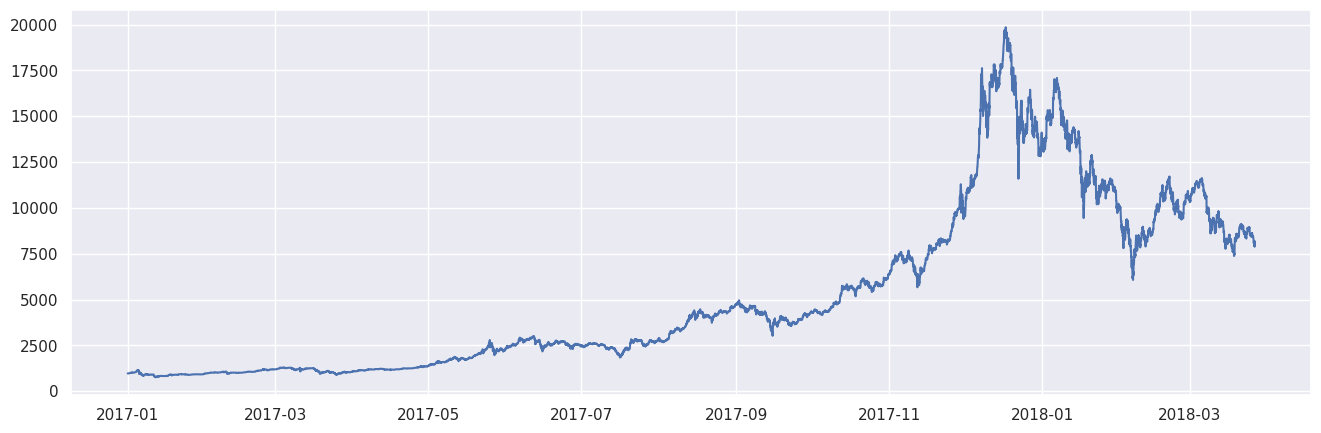

In [8]:
plt.plot(data.ds, data.y)

In [9]:
data.ds.describe()

count                  10801
mean     2017-08-14 00:00:00
min      2017-01-01 00:00:00
25%      2017-04-23 12:00:00
50%      2017-08-14 00:00:00
75%      2017-12-04 12:00:00
max      2018-03-27 00:00:00
Name: ds, dtype: object

### <font color='#eb3483'> Prophet </font>

Now we import prophet

In [17]:
from prophet import Prophet

### <font color='#eb3483'> Fit the model </font>

We create a `Prophet` model object to train and make predictions.

In [18]:
#Check out all parameters
Prophet?

In [19]:
m = Prophet(yearly_seasonality=False, weekly_seasonality="auto", daily_seasonality="auto")

Now we fit the model to the data

In [20]:
%time m.fit(data) # takes about 40 seconds

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4rbor1af/05zznqhk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4rbor1af/tphrsu43.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54949', 'data', 'file=/tmp/tmp4rbor1af/05zznqhk.json', 'init=/tmp/tmp4rbor1af/tphrsu43.json', 'output', 'file=/tmp/tmp4rbor1af/prophet_modelfv6y49sb/prophet_model-20240618070347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:03:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:03:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 798 ms, sys: 39.1 ms, total: 837 ms
Wall time: 8.9 s


### <font color='#eb3483'> Validate our model </font>

Prophet has [some functions](https://facebook.github.io/prophet/docs/diagnostics.html) to evaluate Time series models. For example, we can do model crossvalidation, using the `diagnostics.cross_validation function`

![](https://facebook.github.io/prophet/static/diagnostics_files/diagnostics_3_0.png)

Basically it trains multiple prophet models, given an `initial` number of periods to use as training data,  and evaluate the models on the predictions on a given `horizon` period. If we dont want to run as many predictions as periods on the training dataset we can pass the parameter `period` (to run the predictions every period time)

In [21]:
from prophet.diagnostics import cross_validation

* initial: This parameter specifies the size of the initial training period. In this case, initial="60 days" means that the initial training period will be 60 days.

* horizon: This parameter defines the forecast horizon, which is the length of time into the future for which predictions are made. Here, horizon="7 days" means that the model will make forecasts for the next 7 days.

* period: This parameter specifies the spacing between cutoff dates for cross-validation. Essentially, it defines how often the model will be evaluated. In this case, period="15 days" means that the model will be evaluated every 15 days.

In [22]:
#This takes forever - run the code while we talk about what it's doing!
cv_results = cross_validation(m,  initial="60 days", horizon="7 days", period="15 days")

#Why do we need to do different cv than our usual machine learning?

INFO:prophet:Making 26 forecasts with cutoffs between 2017-03-10 00:00:00 and 2018-03-20 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4rbor1af/a9o2ted7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4rbor1af/rz0e4mm1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32559', 'data', 'file=/tmp/tmp4rbor1af/a9o2ted7.json', 'init=/tmp/tmp4rbor1af/rz0e4mm1.json', 'output', 'file=/tmp/tmp4rbor1af/prophet_model5nafl2s3/prophet_model-20240618070411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:04:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:04:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4rbor1af/wduve3s8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4rbor1af/ap7cqtiu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [23]:
cv_results.shape

(4368, 6)

In [24]:
cv_results.head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-03-10 01:00:00,1259.345176,1223.051299,1296.834164,1206.788113,2017-03-10
1,2017-03-10 02:00:00,1259.973352,1222.745045,1295.424314,1207.478641,2017-03-10
2,2017-03-10 03:00:00,1260.797576,1224.600135,1296.882898,1207.021797,2017-03-10
3,2017-03-10 04:00:00,1261.663668,1224.685595,1299.333228,1204.203248,2017-03-10
4,2017-03-10 05:00:00,1262.192124,1223.697123,1298.850525,1205.313752,2017-03-10
5,2017-03-10 06:00:00,1262.237348,1223.442298,1300.415214,1204.417585,2017-03-10
6,2017-03-10 07:00:00,1262.094232,1226.264458,1298.564609,1196.698951,2017-03-10
7,2017-03-10 08:00:00,1262.196603,1226.698230,1297.379151,1199.070888,2017-03-10
8,2017-03-10 09:00:00,1262.610275,1224.261324,1301.823427,1201.178285,2017-03-10
9,2017-03-10 10:00:00,1262.880778,1225.017716,1300.999319,1201.717237,2017-03-10


We can compute metrics by horizon with the function `performance_metrics`, it will print out common metrics for each horizon we have taken. Usually the farther the horizon, the bigger the error.

In [25]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(cv_results)
df_p.head(20)

#this gives us the metrics for each period forward we are trying to predict
#generally the further out we are trying to predict the less accurate our forecasts are going to be
#this is much easier to visualise in a plot

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 17:00:00,3.593474e+06,1895.645977,1088.320403,0.136768,0.087302,0.131460,0.291108
1,0 days 18:00:00,3.600712e+06,1897.554141,1091.189060,0.136998,0.086936,0.131802,0.288814
2,0 days 19:00:00,3.597843e+06,1896.798060,1093.012746,0.137164,0.086195,0.132122,0.287579
3,0 days 20:00:00,3.578742e+06,1891.756320,1093.112969,0.137078,0.086195,0.132273,0.289873
4,0 days 21:00:00,3.560586e+06,1886.951602,1092.763449,0.137148,0.086195,0.132529,0.293931
5,0 days 22:00:00,3.554547e+06,1885.350713,1093.345035,0.137286,0.085260,0.132800,0.293931
6,0 days 23:00:00,3.553329e+06,1885.027489,1094.864678,0.137521,0.085501,0.133110,0.292167
7,1 days 00:00:00,3.545141e+06,1882.854533,1095.205940,0.137669,0.087787,0.133331,0.294460
8,1 days 01:00:00,3.540265e+06,1881.559308,1096.178526,0.137985,0.087552,0.133705,0.296754
9,1 days 02:00:00,3.538812e+06,1881.173042,1097.402282,0.138407,0.089990,0.134161,0.296754


We can use the function `plot_cross_validation_metric` to assess how prophet model performs.

Dots show the absolute percent error for each prediction in df_cv. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. We see for this forecast that errors around 5% are typical for predictions one month into the future, and that errors increase up to around 11% for predictions that are a year out.

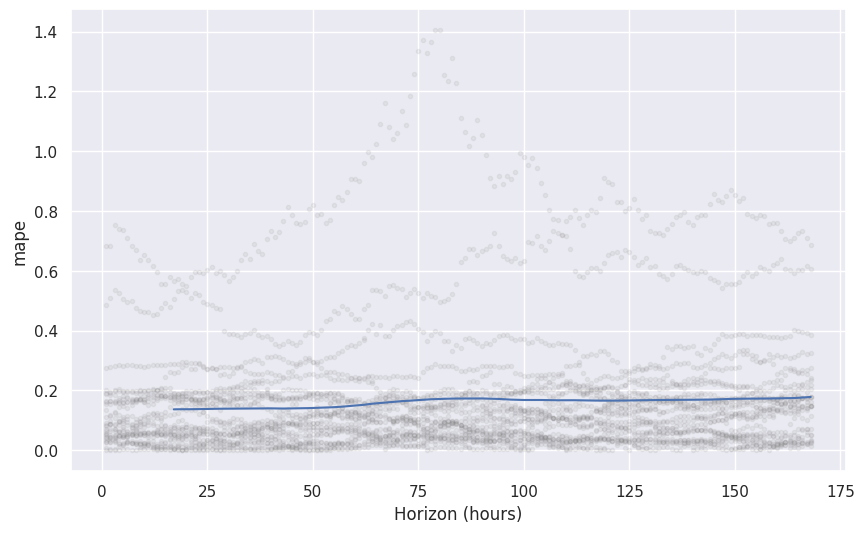

In [26]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(cv_results, metric='mape')

### <font color='#eb3483'> Make future predictions </font>

Now we are ready to make predictions. To do so we just need to fill the `ds` column with future timestamps. Prophet has the utility function `make_future_dataframe()` that creates a dataframe with future timestamps.

By default, this method creates a dataframe with the same timestamps as the training dataset **plus** as many periods as we want in the future. If we only care about creating a dataset with future dates we can use the argument `include_history=False` (it is true by default).

In [27]:
# this makes an empty data frame for which we are going to predict the values
future = m.make_future_dataframe(periods=60, include_history=True)
future.head()

,ds
0,2017-01-01 00:00:00
1,2017-01-01 01:00:00
2,2017-01-01 02:00:00
3,2017-01-01 03:00:00
4,2017-01-01 04:00:00


Now we can forecast using the method `predict`.

In [28]:
forecast = m.predict(future)

In [29]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-01 00:00:00,874.163921,-28.236940,1950.093859,874.163921,874.163921,47.143370,47.143370,47.143370,11.779934,11.779934,11.779934,35.363437,35.363437,35.363437,0.0,0.0,0.0,921.307292
1,2017-01-01 01:00:00,874.307978,-83.090904,1911.938389,874.307978,874.307978,40.864804,40.864804,40.864804,7.882309,7.882309,7.882309,32.982495,32.982495,32.982495,0.0,0.0,0.0,915.172782
2,2017-01-01 02:00:00,874.452034,-53.064729,1946.314718,874.452034,874.452034,32.448923,32.448923,32.448923,1.929284,1.929284,1.929284,30.519639,30.519639,30.519639,0.0,0.0,0.0,906.900957
3,2017-01-01 03:00:00,874.596091,-75.213517,1905.660197,874.596091,874.596091,24.911799,24.911799,24.911799,-3.093172,-3.093172,-3.093172,28.004970,28.004970,28.004970,0.0,0.0,0.0,899.507889
4,2017-01-01 04:00:00,874.740147,-127.990873,1859.875972,874.740147,874.740147,20.591657,20.591657,20.591657,-4.876818,-4.876818,-4.876818,25.468475,25.468475,25.468475,0.0,0.0,0.0,895.331804


We can plot the forecast and see the confidence levels the model has. As time passes it becomes less and less sure about its predictions, which makes sense since this series is pretty volatile.

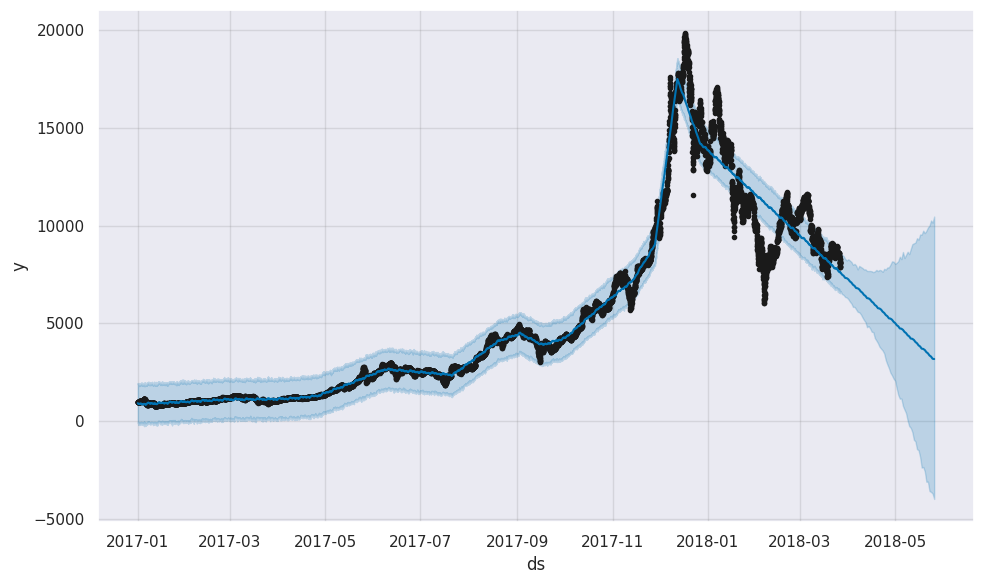

In [30]:
m.plot(forecast);

We can get the time series decomposition with `plot_components`

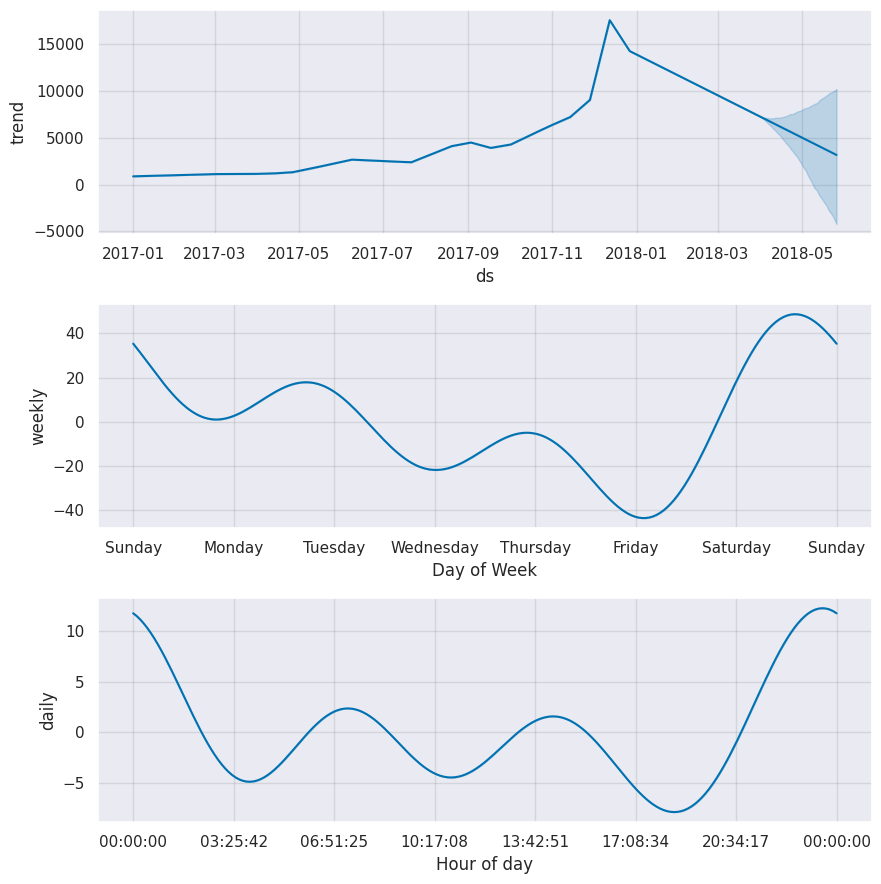

In [31]:
 m.plot_components(forecast);

### <font color='#eb3483'> Bitcoin Data up to 2020 </font>

How did our forecasting model do?

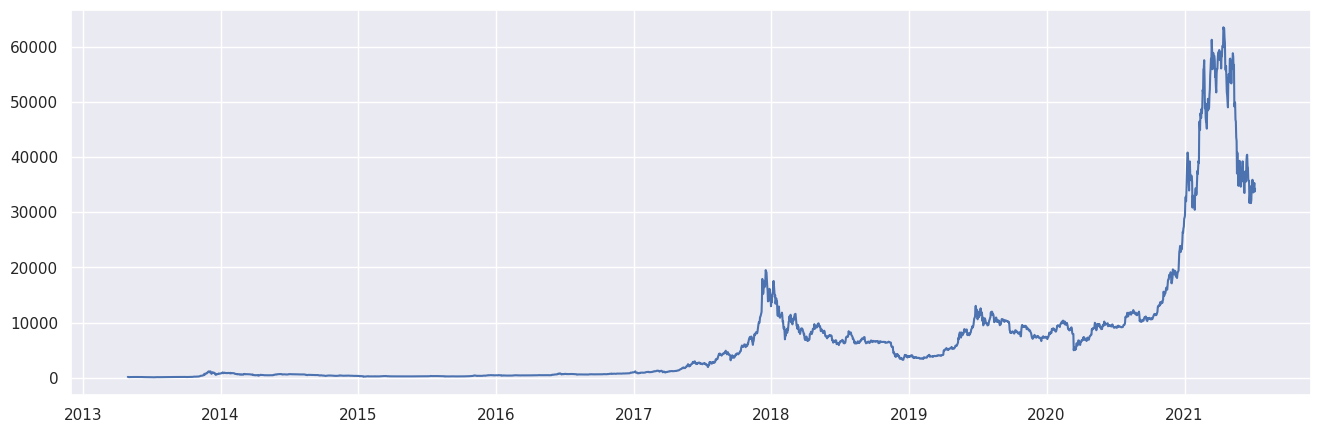

In [32]:
data = pd.read_csv('/content/gdrive/MyDrive/Data Science | Abroad | S1 | Claire/Class Materials/Week 3-6 Special Topics/W5D1 Time Series/Classwork/coin_Bitcoin.csv')
data["ds"] = pd.to_datetime(data.Date)
data["y"] = data.Close
data = data[["ds", "y"]]
data.head()
plt.plot(data.ds, data.y)

This is just the basics of prophet, you can check [this article](https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3) for more in depth techniques